# Data cleaning & EDA
Documentation of this dataset: http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3info.txt

## Import data from PostgreSQL

In [1]:
# Script used for creating the table

# CREATE TABLE IF NOT EXISTS titanic.passengers(
# 	pclass INT,
# 	survived INT,
# 	name TEXT,
# 	sex TEXT,
# 	age TEXT,
# 	sibsp INT,
# 	parch INT,
# 	ticket TEXT,
# 	fare TEXT,
# 	cabin TEXT,
# 	embarked TEXT,
# 	boat TEXT,
# 	body TEXT,
# 	"home.dest" TEXT)

In [2]:
import psycopg2 as pg
import pandas as pd
connection_args = {
    'host': 'localhost',
    'dbname': 'cynthiawang',
    'port': 5432
}

connection = pg.connect(**connection_args) 

In [3]:
query = "SELECT * FROM titanic.passengers;"

titanic_sql = pd.read_sql(query, connection)
titanic_sql.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   pclass     1309 non-null   int64 
 1   survived   1309 non-null   int64 
 2   name       1309 non-null   object
 3   sex        1309 non-null   object
 4   age        1309 non-null   object
 5   sibsp      1309 non-null   int64 
 6   parch      1309 non-null   int64 
 7   ticket     1309 non-null   object
 8   fare       1309 non-null   object
 9   cabin      1309 non-null   object
 10  embarked   1309 non-null   object
 11  boat       1309 non-null   object
 12  body       1309 non-null   object
 13  home.dest  1309 non-null   object
dtypes: int64(4), object(10)
memory usage: 143.3+ KB


## Import data from CSV
Run the cells below for getting the dataset from the csv file

In [4]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import re

In [5]:
titanic = pd.read_csv('TitanicData.csv')

In [6]:
titanic.head(5)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [7]:
# imbalanced target
titanic.survived.value_counts()

0    809
1    500
Name: survived, dtype: int64

In [8]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   pclass     1309 non-null   int64 
 1   survived   1309 non-null   int64 
 2   name       1309 non-null   object
 3   sex        1309 non-null   object
 4   age        1309 non-null   object
 5   sibsp      1309 non-null   int64 
 6   parch      1309 non-null   int64 
 7   ticket     1309 non-null   object
 8   fare       1309 non-null   object
 9   cabin      1309 non-null   object
 10  embarked   1309 non-null   object
 11  boat       1309 non-null   object
 12  body       1309 non-null   object
 13  home.dest  1309 non-null   object
dtypes: int64(4), object(10)
memory usage: 143.3+ KB


In [9]:
# use NaN to represent missing value
df = titanic.copy()
df.loc[df['age'] == '?', 'age'] = np.nan
df.loc[df['fare'] == '?', 'fare'] = np.nan
df.loc[df['fare'] == '0', 'fare'] = np.nan

In [10]:
df.age.isnull().sum()

263

In [11]:
# 1000+ missing values; unlikely to be a useful feature
df.drop(columns=['cabin'], inplace = True)

In [12]:
df.loc[df['embarked'] == '?', 'embarked'] = np.nan
df.embarked.isnull().sum()

2

In [13]:
df.loc[df['boat'] == '?', 'boat'] = np.nan

In [14]:
# most of victims didn't have boat number (23 survivors didn't have boat number)
df[df.boat.isnull()].survived.value_counts()

0    800
1     23
Name: survived, dtype: int64

In [15]:
# most of survivors had boat number (9 victims had boat number)
df[df.boat.notnull()].survived.value_counts()

1    477
0      9
Name: survived, dtype: int64

In [16]:
# highly related to survival but not a predictor of survival
df.drop(columns=['boat'], inplace = True)

# body identification number
df.drop(columns=['body'], inplace = True)

# destination; 500+ missing values
df.drop(columns=['home.dest'], inplace = True)

In [17]:
# convert to the right data types
df['age'] = pd.to_numeric(df['age'])
df['fare'] = pd.to_numeric(df['fare'])

In [18]:
# calculate individual ticket fare (group by ticket number)

ticket_count = pd.DataFrame(df.ticket.value_counts()).reset_index()
ticket_count.rename(columns = {'index':'ticket','ticket':'group_size'},inplace = True)
df = df.merge(ticket_count, on = 'ticket')
df['individual_fare'] = df['fare']/df['group_size']

In [19]:
# fill missing data (age, embarked)

df.age.fillna(df.age.median(),inplace=True)
df['embarked'].fillna((np.random.choice(df[df['embarked'] != np.nan]["embarked"])), inplace =True)

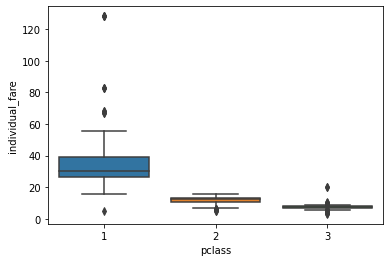

In [20]:
sns.boxplot(x="pclass", y="individual_fare", data=df)

In [21]:
# fill missing individual fare values (ticket prices are influenced by passangers' classes)

class1_median = df[df.pclass == 1].individual_fare.median()
class2_median = df[df.pclass == 2].individual_fare.median()
class3_median = df[df.pclass == 3].individual_fare.median()
df.loc[((df.pclass == 1)&(df.individual_fare.isnull())), 'individual_fare'] = class1_median
df.loc[((df.pclass == 2)&(df.individual_fare.isnull())), 'individual_fare'] = class2_median
df.loc[((df.pclass == 3)&(df.individual_fare.isnull())), 'individual_fare'] = class3_median

In [22]:
class1_median_f = df[df.pclass == 1].fare.median()
class2_median_f = df[df.pclass == 2].fare.median()
class3_median_f = df[df.pclass == 3].fare.median()
df.loc[((df.pclass == 1)&(df.fare.isnull())), 'fare'] = class1_median_f
df.loc[((df.pclass == 2)&(df.fare.isnull())), 'fare'] = class2_median_f
df.loc[((df.pclass == 3)&(df.fare.isnull())), 'fare'] = class3_median_f

In [23]:
df.describe()

,pclass,survived,age,sibsp,parch,fare,group_size,individual_fare
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,2.294882,0.381971,29.503183,0.498854,0.385027,33.698007,2.101604,14.994367
std,0.837836,0.486055,12.905246,1.041658,0.865560,51.677126,1.779832,13.497393
min,1.000000,0.000000,0.166700,0.000000,0.000000,3.170800,1.000000,3.170800
25%,2.000000,0.000000,22.000000,0.000000,0.000000,7.925000,1.000000,7.729200
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.500000,1.000000,8.158300
75%,3.000000,1.000000,35.000000,1.000000,0.000000,31.387500,3.000000,15.050000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,11.000000,128.082300


In [24]:
# checked original website; outliers but not error 
df[df.individual_fare > 100]

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,embarked,group_size,individual_fare
84,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,C,4,128.0823
85,1,1,"Cardeza, Mrs. James Warburton Martinez (Charlo...",female,58.0,0,1,PC 17755,512.3292,C,4,128.0823
86,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,C,4,128.0823
87,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,C,4,128.0823


In [25]:
df_2 = df.copy()
df_2.drop(columns=['ticket'], inplace = True)

In [26]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 1308
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   pclass           1309 non-null   int64  
 1   survived         1309 non-null   int64  
 2   name             1309 non-null   object 
 3   sex              1309 non-null   object 
 4   age              1309 non-null   float64
 5   sibsp            1309 non-null   int64  
 6   parch            1309 non-null   int64  
 7   fare             1309 non-null   float64
 8   embarked         1309 non-null   object 
 9   group_size       1309 non-null   int64  
 10  individual_fare  1309 non-null   float64
dtypes: float64(3), int64(5), object(3)
memory usage: 122.7+ KB


/Users/cynthiawang/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


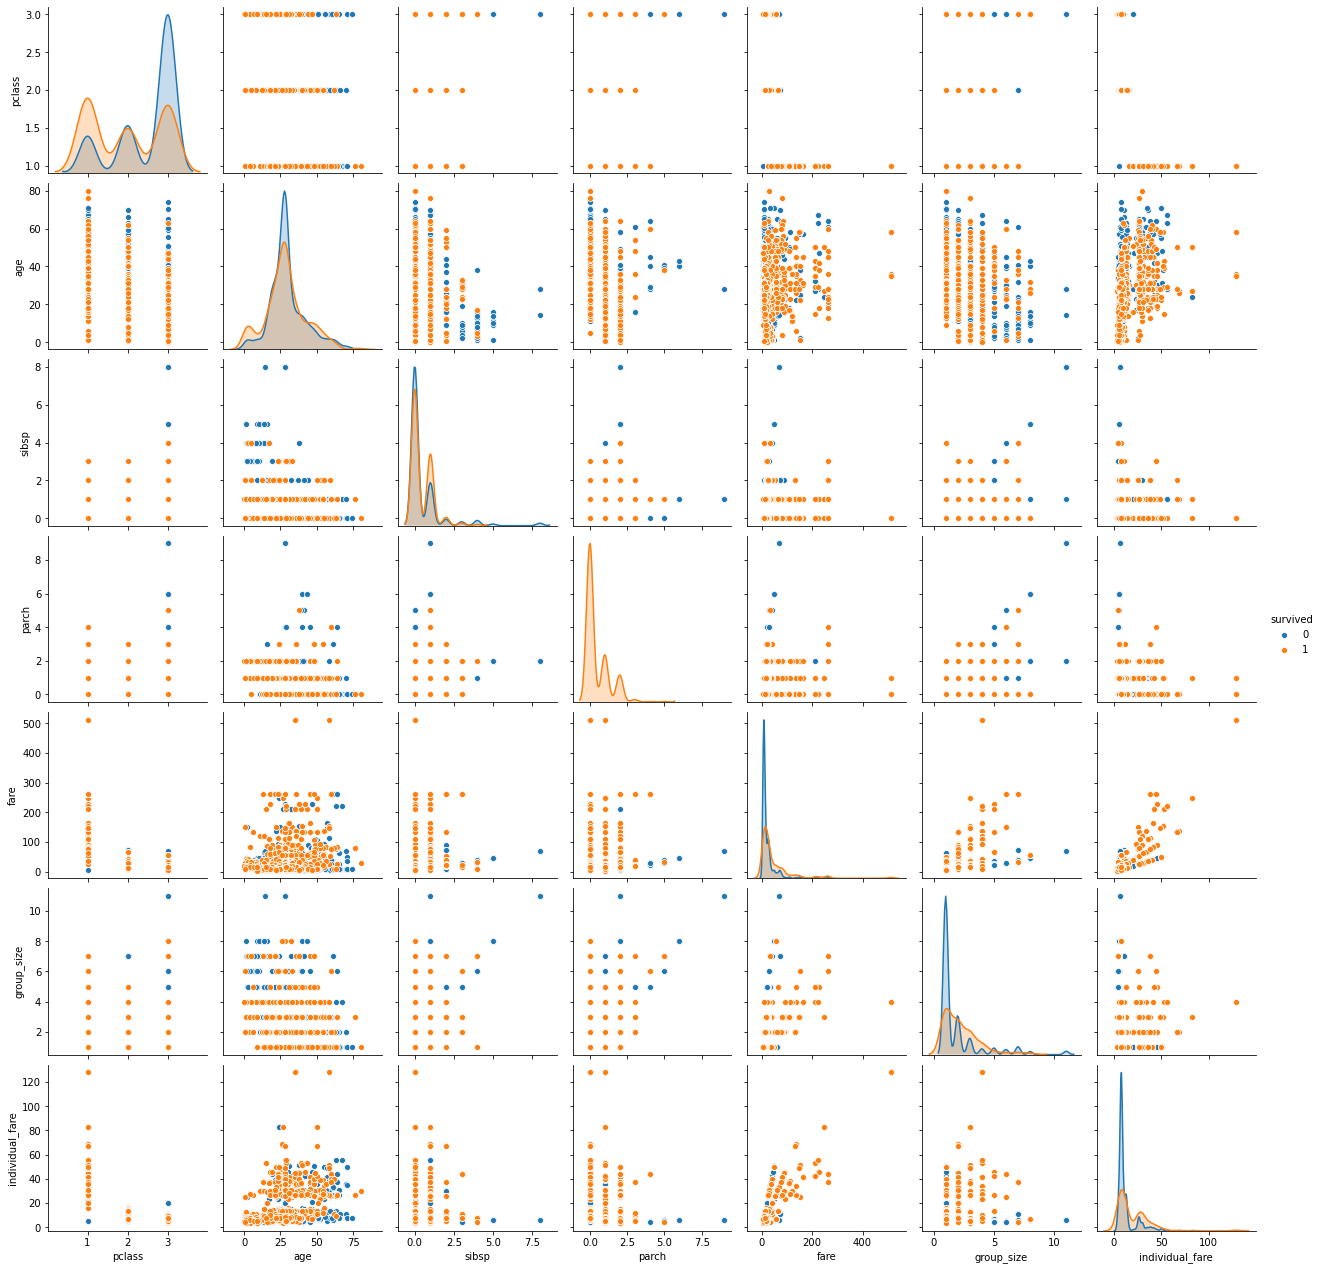

In [27]:
sns.pairplot(df_2,hue = 'survived')

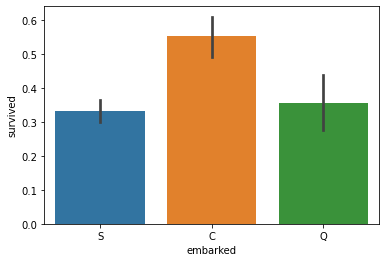

In [28]:
sns.barplot(x = 'embarked',y='survived',data=df_2)

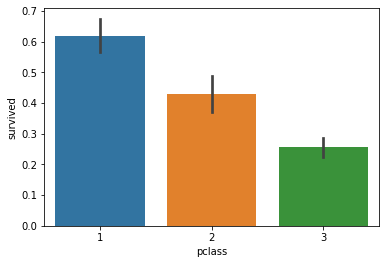

In [29]:
sns.barplot(x = 'pclass',y='survived',data=df_2)

# Split data
So far, we generated group_size and individual_fare, dropped ticket number, body, boat and home destination

## Train/test split

In [30]:
X_train, X_test, y_train, y_test = train_test_split(df_2.drop(columns = ['survived']), df_2.survived, 
                                                    test_size = 0.2, random_state=42)

In [31]:
X_train.head(5)

,pclass,name,sex,age,sibsp,parch,fare,embarked,group_size,individual_fare
772,3,"de Mulder, Mr. Theodore",male,30.0,0,0,9.5000,S,1,9.500000
543,2,"Portaluppi, Mr. Emilio Ilario Giuseppe",male,30.0,0,0,12.7375,C,1,12.737500
289,1,"Smart, Mr. John Montgomery",male,56.0,0,0,26.5500,S,1,26.550000
10,1,"Anderson, Mr. Harry",male,48.0,0,0,26.5500,S,1,26.550000
147,1,"Thayer, Mrs. John Borland (Marian Longstreth M...",female,39.0,1,1,110.8833,C,4,27.720825


In [32]:
# X_train_1: no other feature engineering yet

X_train_1 = X_train.copy()
X_train_1.drop(columns=['name'], inplace = True)
X_train_1 = pd.get_dummies(X_train_1,drop_first = True)
X_train_1

,pclass,age,sibsp,parch,fare,group_size,individual_fare,sex_male,embarked_Q,embarked_S
772,3,30.0,0,0,9.5000,1,9.500000,1,0,1
543,2,30.0,0,0,12.7375,1,12.737500,1,0,0
289,1,56.0,0,0,26.5500,1,26.550000,1,0,1
10,1,48.0,0,0,26.5500,1,26.550000,1,0,1
147,1,39.0,1,1,110.8833,4,27.720825,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1095,3,32.0,0,0,7.7750,1,7.775000,1,0,1
1130,3,28.0,0,0,8.1375,1,8.137500,0,1,0
1294,3,28.0,0,0,7.5500,1,7.550000,1,0,1
860,3,20.0,0,0,9.5000,1,9.500000,1,0,1


## Train/Validation Split

In [33]:
X_train_1, X_val_1, y_train_val, y_test_val = train_test_split(X_train_1, y_train, test_size = 0.2
                                                                     , random_state=42)

# Try a baseline model with logistic regression - choose F1 as metric 
Single feature individual_fare in LR

In [34]:
X_train_infare, X_val_infare = X_train_1, X_val_1

In [35]:
lm1 = LogisticRegression(C=1000)
lm1.fit(X_train_infare[['individual_fare']], y_train_val)

y_predict_val = lm1.predict(X_val_infare[['individual_fare']])

print('accuracy:', lm1.score(X_val_infare[['individual_fare']], y_test_val))
print('precision:', precision_score(y_test_val, y_predict_val))
print('recall:', recall_score(y_test_val, y_predict_val))
print('F1:', f1_score(y_test_val,y_predict_val))
print('Coefficient:', lm1.coef_)

accuracy: 0.7
precision: 0.6875
recall: 0.4074074074074074
F1: 0.5116279069767441
Coefficient: [[0.04737932]]


# Try to fix the class imbalance issue

## Oversampling

In [36]:
## SMOTE

import imblearn.over_sampling
n_pos = np.sum(y_train_val == 1)
n_neg = np.sum(y_train_val == 0)
ratio = {1: n_pos*1.5, 0: n_neg}
smote = imblearn.over_sampling.SMOTE(random_state = 42)

In [37]:
X_train_infareS, y_train_valS = smote.fit_sample(X_train_infare, y_train_val)

In [38]:
lm2 = LogisticRegression(C=1000)
lm2.fit(X_train_infareS[['individual_fare']], y_train_valS)

y_predict_val = lm2.predict(X_val_infare[['individual_fare']])

print('accuracy:', accuracy_score(y_test_val, y_predict_val))
print('precision:', precision_score(y_test_val, y_predict_val))
print('recall:', recall_score(y_test_val, y_predict_val))
print('F1:', f1_score(y_test_val,y_predict_val))

accuracy: 0.6952380952380952
precision: 0.6491228070175439
recall: 0.4567901234567901
F1: 0.536231884057971


## Class Weights

In [39]:
lm3 = LogisticRegression(class_weight='balanced', solver='liblinear',C=1000)
lm3.fit(X_train_infare[['individual_fare']], y_train_val)

y_predict_val = lm3.predict(X_val_infare[['individual_fare']])

print('accuracy:', accuracy_score(y_test_val, y_predict_val))
print('precision:', precision_score(y_test_val, y_predict_val))
print('recall:', recall_score(y_test_val, y_predict_val))
print('F1:', f1_score(y_test_val,y_predict_val))

accuracy: 0.6952380952380952
precision: 0.6491228070175439
recall: 0.4567901234567901
F1: 0.536231884057971


## Threshold Adjustment

Best F1 score 0.589 at prob decision threshold >= 0.309


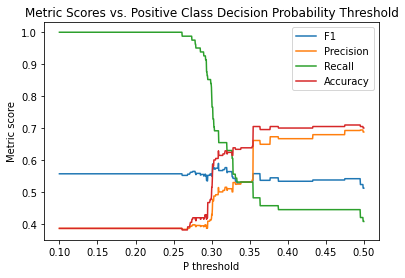

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

thresh_ps = np.linspace(.10,.50,1000)
model_val_probs = lm1.predict_proba(X_val_infare[['individual_fare']])[:,1] # positive class probs

f1_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f1_scores.append(f1_score(y_test_val, model_val_labels))    
    prec_scores.append(precision_score(y_test_val, model_val_labels))
    rec_scores.append(recall_score(y_test_val, model_val_labels))
    acc_scores.append(accuracy_score(y_test_val, model_val_labels))
    
plt.plot(thresh_ps, f1_scores)
plt.plot(thresh_ps, prec_scores)
plt.plot(thresh_ps, rec_scores)
plt.plot(thresh_ps, acc_scores)

plt.title('Metric Scores vs. Positive Class Decision Probability Threshold')
plt.legend(['F1','Precision','Recall','Accuracy'])
plt.xlabel('P threshold')
plt.ylabel('Metric score')

best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('Best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

Best F1 score 0.588 at prob decision threshold >= 0.415


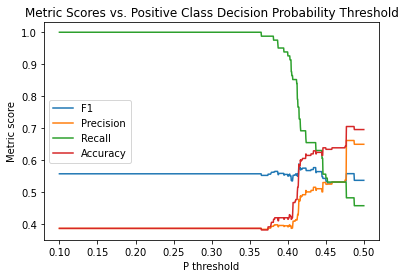

In [41]:
# Try using the upsampled data

thresh_ps = np.linspace(.10,.50,1000)
model_val_probs = lm2.predict_proba(X_val_infare[['individual_fare']])[:,1] # positive class probs

f1_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f1_scores.append(f1_score(y_test_val, model_val_labels))    
    prec_scores.append(precision_score(y_test_val, model_val_labels))
    rec_scores.append(recall_score(y_test_val, model_val_labels))
    acc_scores.append(accuracy_score(y_test_val, model_val_labels))
    
plt.plot(thresh_ps, f1_scores)
plt.plot(thresh_ps, prec_scores)
plt.plot(thresh_ps, rec_scores)
plt.plot(thresh_ps, acc_scores)

plt.title('Metric Scores vs. Positive Class Decision Probability Threshold')
plt.legend(['F1','Precision','Recall','Accuracy'])
plt.xlabel('P threshold')
plt.ylabel('Metric score')

best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('Best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

All the methods for fixing imbalanced class issues improved F1.

# Add more features
## add pclass

In [42]:
# new training data label
X_train_2F, X_val_2F = X_train_1[['individual_fare','pclass']], X_val_1[['individual_fare','pclass']]

In [43]:
## Logistic regression

lm4 = LogisticRegression(C=2000)
lm4.fit(X_train_2F, y_train_val)

y_predict_val = lm4.predict(X_val_2F)

print('accuracy:', accuracy_score(y_test_val, y_predict_val))
print('precision:', precision_score(y_test_val, y_predict_val))
print('recall:', recall_score(y_test_val, y_predict_val))
print('F1:', f1_score(y_test_val,y_predict_val))
print('Coefficient:', lm1.coef_)

accuracy: 0.7047619047619048
precision: 0.6792452830188679
recall: 0.4444444444444444
F1: 0.5373134328358209
Coefficient: [[0.04737932]]


In [44]:
## Oversampling

X_train_2FS, y_train_valS = smote.fit_sample(X_train_2F, y_train_val)

lm5 = LogisticRegression(C=1000)
lm5.fit(X_train_2FS, y_train_valS)

y_predict_val = lm5.predict(X_val_2F)

print('accuracy:', accuracy_score(y_test_val, y_predict_val))
print('precision:', precision_score(y_test_val, y_predict_val))
print('recall:', recall_score(y_test_val, y_predict_val))
print('F1:', f1_score(y_test_val,y_predict_val))
print('Coefficient:', lm5.coef_)

accuracy: 0.6666666666666666
precision: 0.5523809523809524
recall: 0.7160493827160493
F1: 0.6236559139784947
Coefficient: [[ 6.65764214e-05 -7.94090937e-01]]


Best F1 score 0.624 at prob decision threshold >= 0.259


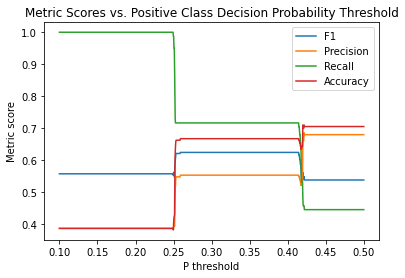

In [45]:
## Threshold adjustment

thresh_ps = np.linspace(.10,.50,1000)
model_val_probs = lm4.predict_proba(X_val_2F)[:,1] # positive class probs

f1_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f1_scores.append(f1_score(y_test_val, model_val_labels))    
    prec_scores.append(precision_score(y_test_val, model_val_labels))
    rec_scores.append(recall_score(y_test_val, model_val_labels))
    acc_scores.append(accuracy_score(y_test_val, model_val_labels))
    
plt.plot(thresh_ps, f1_scores)
plt.plot(thresh_ps, prec_scores)
plt.plot(thresh_ps, rec_scores)
plt.plot(thresh_ps, acc_scores)

plt.title('Metric Scores vs. Positive Class Decision Probability Threshold')
plt.legend(['F1','Precision','Recall','Accuracy'])
plt.xlabel('P threshold')
plt.ylabel('Metric score')

best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('Best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

Adding one more feature increased the F1! pclass has negative impact on survival rate, which implies people from 3rd class had lower survival rate than those from 1st class.

## add group_size

In [46]:
# new training data label
X_train_3F, X_val_3F = X_train_1[['individual_fare','pclass','group_size']], X_val_1[['individual_fare','pclass','group_size']]

In [47]:
## Logistic regression

lm6 = LogisticRegression(C=1000)
lm6.fit(X_train_3F, y_train_val)

y_predict_val = lm6.predict(X_val_3F)

print('accuracy:', accuracy_score(y_test_val, y_predict_val))
print('precision:', precision_score(y_test_val, y_predict_val))
print('recall:', recall_score(y_test_val, y_predict_val))
print('F1:', f1_score(y_test_val,y_predict_val))
print('Coefficient:', lm6.coef_)

accuracy: 0.7047619047619048
precision: 0.6792452830188679
recall: 0.4444444444444444
F1: 0.5373134328358209
Coefficient: [[ 0.00269057 -0.75041981  0.02642545]]


In [48]:
## Oversampling

X_train_3FS, y_train_valS = smote.fit_sample(X_train_3F, y_train_val)

lm7 = LogisticRegression(C=1000)
lm7.fit(X_train_3FS, y_train_valS)

y_predict_val = lm7.predict(X_val_3F)

print('accuracy:', accuracy_score(y_test_val, y_predict_val))
print('precision:', precision_score(y_test_val, y_predict_val))
print('recall:', recall_score(y_test_val, y_predict_val))
print('F1:', f1_score(y_test_val,y_predict_val))

accuracy: 0.6666666666666666
precision: 0.5523809523809524
recall: 0.7160493827160493
F1: 0.6236559139784947


In [49]:
## Class weights

lm11 = LogisticRegression(class_weight='balanced', solver='liblinear',C=1)
lm11.fit(X_train_3F, y_train_val)

y_predict_val = lm11.predict(X_val_3F)

print('accuracy:', accuracy_score(y_test_val, y_predict_val))
print('precision:', precision_score(y_test_val, y_predict_val))
print('recall:', recall_score(y_test_val, y_predict_val))
print('F1:', f1_score(y_test_val,y_predict_val))

accuracy: 0.6666666666666666
precision: 0.5523809523809524
recall: 0.7160493827160493
F1: 0.6236559139784947


Best F1 score 0.675 at prob decision threshold >= 0.413


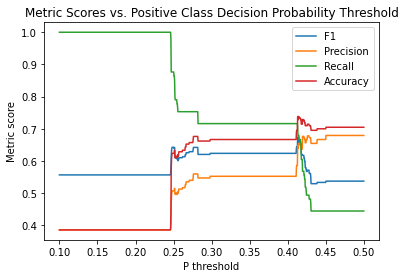

In [50]:
## Threshold adjustment

thresh_ps = np.linspace(.10,.50,1000)
model_val_probs = lm6.predict_proba(X_val_3F)[:,1] # positive class probs

f1_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f1_scores.append(f1_score(y_test_val, model_val_labels))    
    prec_scores.append(precision_score(y_test_val, model_val_labels))
    rec_scores.append(recall_score(y_test_val, model_val_labels))
    acc_scores.append(accuracy_score(y_test_val, model_val_labels))
    
plt.plot(thresh_ps, f1_scores)
plt.plot(thresh_ps, prec_scores)
plt.plot(thresh_ps, rec_scores)
plt.plot(thresh_ps, acc_scores)

plt.title('Metric Scores vs. Positive Class Decision Probability Threshold')
plt.legend(['F1','Precision','Recall','Accuracy'])
plt.xlabel('P threshold')
plt.ylabel('Metric score')

best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('Best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

After adding group_size, only thredhold adjustment can improve F1 score.

Note: for now, regularization doesn't have impact on F1 score.

## add age

In [51]:
# new training data label
X_train_4F = X_train_1[['individual_fare','pclass','group_size','age']]
X_val_4F = X_val_1[['individual_fare','pclass','group_size','age']]

In [52]:
## Logistic regression

lm8 = LogisticRegression(C=1)
lm8.fit(X_train_4F, y_train_val)

y_predict_val = lm8.predict(X_val_4F)

print('accuracy:', accuracy_score(y_test_val, y_predict_val))
print('precision:', precision_score(y_test_val, y_predict_val))
print('recall:', recall_score(y_test_val, y_predict_val))
print('F1:', f1_score(y_test_val,y_predict_val))
print('Coefficient:', lm8.coef_)

accuracy: 0.719047619047619
precision: 0.671875
recall: 0.5308641975308642
F1: 0.593103448275862
Coefficient: [[ 0.00991896 -0.89705605 -0.02993586 -0.03493323]]


In [53]:
## Oversampling

X_train_4FS, y_train_valS = smote.fit_sample(X_train_4F, y_train_val)

lm9 = LogisticRegression(C=1)
lm9.fit(X_train_4FS, y_train_valS)

y_predict_val = lm9.predict(X_val_4F)

print('accuracy:', accuracy_score(y_test_val, y_predict_val))
print('precision:', precision_score(y_test_val, y_predict_val))
print('recall:', recall_score(y_test_val, y_predict_val))
print('F1:', f1_score(y_test_val,y_predict_val))

accuracy: 0.6904761904761905
precision: 0.5816326530612245
recall: 0.7037037037037037
F1: 0.6368715083798882


In [54]:
# Class weights

lm10 = LogisticRegression(class_weight='balanced', solver='liblinear',C=1)
lm10.fit(X_train_4F, y_train_val)

y_predict_val = lm10.predict(X_val_4F)

print('accuracy:', accuracy_score(y_test_val, y_predict_val))
print('precision:', precision_score(y_test_val, y_predict_val))
print('recall:', recall_score(y_test_val, y_predict_val))
print('F1:', f1_score(y_test_val,y_predict_val))

# regulization improved F1 here

accuracy: 0.6952380952380952
precision: 0.5876288659793815
recall: 0.7037037037037037
F1: 0.6404494382022472


Best F1 score 0.640 at prob decision threshold >= 0.380


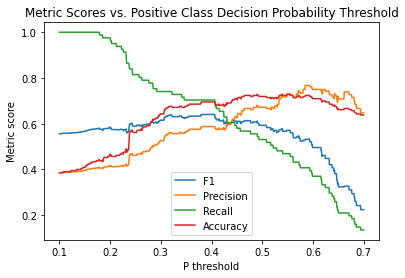

In [55]:
## Threshold adjustment

thresh_ps = np.linspace(.10,.70,1000)
model_val_probs = lm8.predict_proba(X_val_4F)[:,1] # positive class probs

f1_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f1_scores.append(f1_score(y_test_val, model_val_labels))    
    prec_scores.append(precision_score(y_test_val, model_val_labels))
    rec_scores.append(recall_score(y_test_val, model_val_labels))
    acc_scores.append(accuracy_score(y_test_val, model_val_labels))
    
plt.plot(thresh_ps, f1_scores)
plt.plot(thresh_ps, prec_scores)
plt.plot(thresh_ps, rec_scores)
plt.plot(thresh_ps, acc_scores)

plt.title('Metric Scores vs. Positive Class Decision Probability Threshold')
plt.legend(['F1','Precision','Recall','Accuracy'])
plt.xlabel('P threshold')
plt.ylabel('Metric score')

best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('Best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

Adding age improves F1 score.

## Now put everything into the model

In [56]:
## Logistic regression

lm12 = LogisticRegression(C=1000, solver='liblinear')
lm12.fit(X_train_1, y_train_val)

y_predict_val = lm12.predict(X_val_1)

print('accuracy:', accuracy_score(y_test_val, y_predict_val))
print('precision:', precision_score(y_test_val, y_predict_val))
print('recall:', recall_score(y_test_val, y_predict_val))
print('F1:', f1_score(y_test_val,y_predict_val))
print('Coefficient:', lm12.coef_)

accuracy: 0.719047619047619
precision: 0.6410256410256411
recall: 0.6172839506172839
F1: 0.6289308176100629
Coefficient: [[-1.18469232 -0.04078792 -0.23562966  0.21046563  0.00791018 -0.29272564
  -0.02114248 -2.76867237 -0.57234448 -0.50700253]]


In [57]:
## Oversampling

X_train_1S, y_train_valS = smote.fit_sample(X_train_1, y_train_val)

lm13 = LogisticRegression(C=1000, solver='liblinear')
lm13.fit(X_train_1S, y_train_valS)

y_predict_val = lm13.predict(X_val_1)

print('accuracy:', accuracy_score(y_test_val, y_predict_val))
print('precision:', precision_score(y_test_val, y_predict_val))
print('recall:', recall_score(y_test_val, y_predict_val))
print('F1:', f1_score(y_test_val,y_predict_val))

accuracy: 0.7095238095238096
precision: 0.6190476190476191
recall: 0.6419753086419753
F1: 0.6303030303030304


In [58]:
# Class weights

lm14 = LogisticRegression(class_weight='balanced', solver='liblinear',C=1000)
lm14.fit(X_train_1, y_train_val)

y_predict_val = lm14.predict(X_val_1)

print('accuracy:', accuracy_score(y_test_val, y_predict_val))
print('precision:', precision_score(y_test_val, y_predict_val))
print('recall:', recall_score(y_test_val, y_predict_val))
print('F1:', f1_score(y_test_val,y_predict_val))

accuracy: 0.719047619047619
precision: 0.625
recall: 0.6790123456790124
F1: 0.650887573964497


Best F1 score 0.691 at prob decision threshold >= 0.238


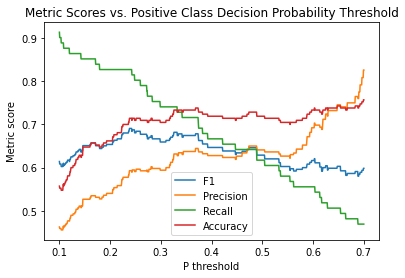

In [59]:
## Threshold adjustment

thresh_ps = np.linspace(.10,.70,1000)
model_val_probs = lm12.predict_proba(X_val_1)[:,1] # positive class probs

f1_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f1_scores.append(f1_score(y_test_val, model_val_labels))    
    prec_scores.append(precision_score(y_test_val, model_val_labels))
    rec_scores.append(recall_score(y_test_val, model_val_labels))
    acc_scores.append(accuracy_score(y_test_val, model_val_labels))
    
plt.plot(thresh_ps, f1_scores)
plt.plot(thresh_ps, prec_scores)
plt.plot(thresh_ps, rec_scores)
plt.plot(thresh_ps, acc_scores)

plt.title('Metric Scores vs. Positive Class Decision Probability Threshold')
plt.legend(['F1','Precision','Recall','Accuracy'])
plt.xlabel('P threshold')
plt.ylabel('Metric score')

best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('Best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

Using the whole model gives the highest F1 so far (Threshold adjustment is the best way to fix class imbalance).

# More feature engineering

## Create family size

sibsp:
- Sibling:  Brother, Sister, Stepbrother, or Stepsister of Passenger Aboard Titanic
- Spouse:   Husband or Wife of Passenger Aboard Titanic (Mistresses and Fiancées Ignored)  

parch:
- Parent:   Mother or Father of Passenger Aboard Titanic
- Child:    Son, Daughter, Stepson, or Stepdaughter of Passenger Aboard Titanic

Adding these features up cound generate a measure for number of family members on board.

In [60]:
df_3 = df_2.copy()

In [61]:
df_3['fam_size'] = df['sibsp'] + df['parch']

In [62]:
df_3

,pclass,survived,name,sex,age,sibsp,parch,fare,embarked,group_size,individual_fare,fam_size
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,211.3375,S,4,52.834375,0
1,1,1,"Kreuchen, Miss. Emilie",female,39.0000,0,0,211.3375,S,4,52.834375,0
2,1,1,"Madill, Miss. Georgette Alexandra",female,15.0000,0,1,211.3375,S,4,52.834375,1
3,1,1,"Robert, Mrs. Edward Scott (Elisabeth Walton Mc...",female,43.0000,0,1,211.3375,S,4,52.834375,1
4,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,151.5500,S,6,25.258333,3
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,0,"Zabour, Miss. Hileni",female,14.5000,1,0,14.4542,C,2,7.227100,1
1305,3,0,"Zabour, Miss. Thamine",female,28.0000,1,0,14.4542,C,2,7.227100,1
1306,3,0,"Zakarian, Mr. Mapriededer",male,26.5000,0,0,7.2250,C,1,7.225000,0
1307,3,0,"Zakarian, Mr. Ortin",male,27.0000,0,0,7.2250,C,1,7.225000,0


/Users/cynthiawang/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


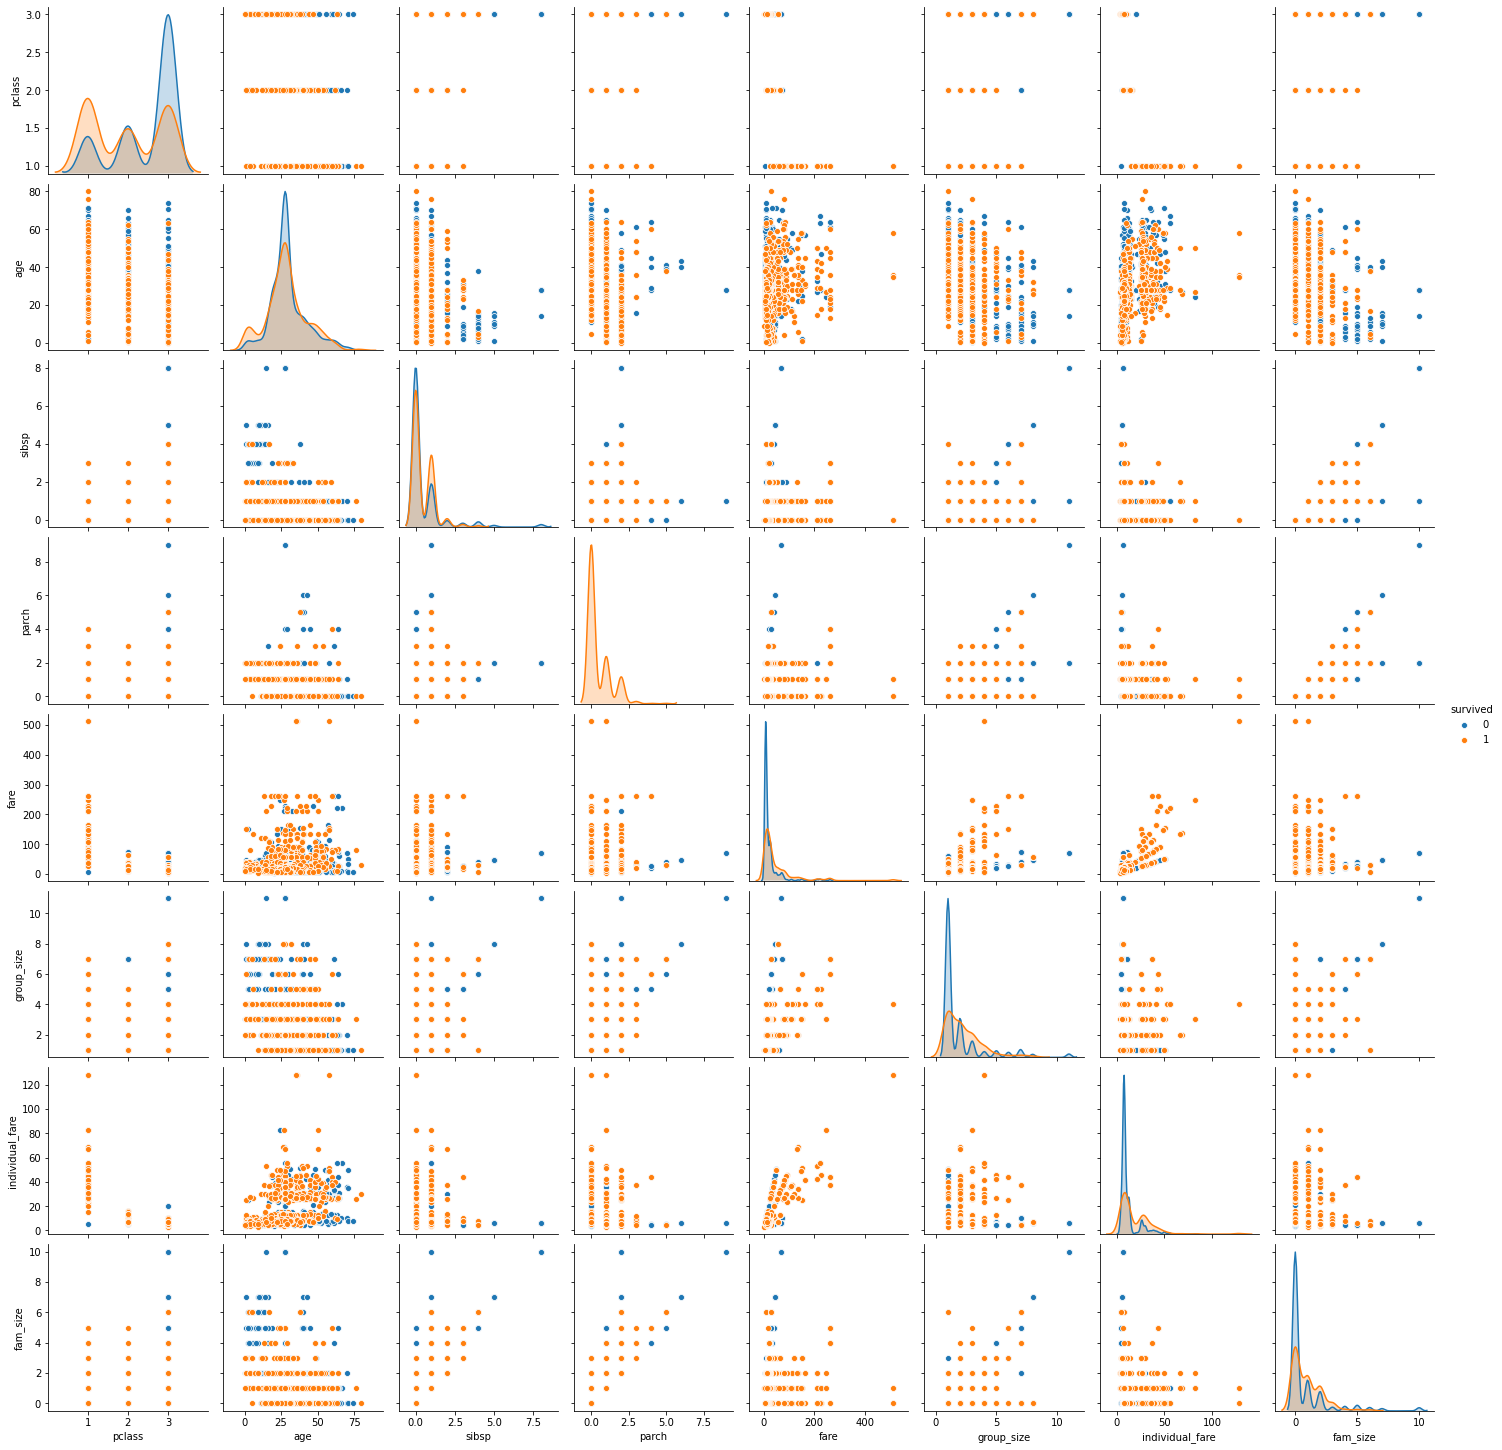

In [63]:
sns.pairplot(df_3,hue = 'survived')

### Test on model

In [64]:
# Split again with new feature
X_train_new, X_test_new, y_train, y_test = train_test_split(df_3.drop(columns = ['survived']), df_3.survived, 
                                                    test_size = 0.2, random_state=42)

In [65]:
X_train_2 = X_train_new.copy()
X_train_2.drop(columns=['name'], inplace = True)
X_train_2 = pd.get_dummies(X_train_2,drop_first = True)
X_train_2

,pclass,age,sibsp,parch,fare,group_size,individual_fare,fam_size,sex_male,embarked_Q,embarked_S
772,3,30.0,0,0,9.5000,1,9.500000,0,1,0,1
543,2,30.0,0,0,12.7375,1,12.737500,0,1,0,0
289,1,56.0,0,0,26.5500,1,26.550000,0,1,0,1
10,1,48.0,0,0,26.5500,1,26.550000,0,1,0,1
147,1,39.0,1,1,110.8833,4,27.720825,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1095,3,32.0,0,0,7.7750,1,7.775000,0,1,0,1
1130,3,28.0,0,0,8.1375,1,8.137500,0,0,1,0
1294,3,28.0,0,0,7.5500,1,7.550000,0,1,0,1
860,3,20.0,0,0,9.5000,1,9.500000,0,1,0,1


In [66]:
X_train_2, X_val_2, y_train_val, y_test_val = train_test_split(X_train_2, y_train, test_size = 0.2
                                                                     , random_state=42)

In [67]:
## Logistic regression

lm15 = LogisticRegression(C=10, solver='liblinear')
lm15.fit(X_train_2, y_train_val)

y_predict_val = lm15.predict(X_val_2)

print('accuracy:', accuracy_score(y_test_val, y_predict_val))
print('precision:', precision_score(y_test_val, y_predict_val))
print('recall:', recall_score(y_test_val, y_predict_val))
print('F1:', f1_score(y_test_val,y_predict_val))
print('Coefficient:', lm15.coef_)

# no change in F1

accuracy: 0.719047619047619
precision: 0.6410256410256411
recall: 0.6172839506172839
F1: 0.6289308176100629
Coefficient: [[-1.09177075 -0.03898269 -0.22681858  0.21086033  0.00687461 -0.25996251
  -0.01399143 -0.01595824 -2.72841616 -0.53725856 -0.46583077]]


In [68]:
## Oversampling

X_train_2S, y_train_valS = smote.fit_sample(X_train_2, y_train_val)

lm16 = LogisticRegression(C=10, solver='liblinear')
lm16.fit(X_train_2S, y_train_valS)

y_predict_val = lm16.predict(X_val_2)

print('accuracy:', accuracy_score(y_test_val, y_predict_val))
print('precision:', precision_score(y_test_val, y_predict_val))
print('recall:', recall_score(y_test_val, y_predict_val))
print('F1:', f1_score(y_test_val,y_predict_val))

accuracy: 0.7142857142857143
precision: 0.6265060240963856
recall: 0.6419753086419753
F1: 0.6341463414634146


In [69]:
# Class weights

lm17 = LogisticRegression(class_weight='balanced', solver='liblinear',C=1000)
lm17.fit(X_train_2, y_train_val)

y_predict_val = lm17.predict(X_val_2)

print('accuracy:', accuracy_score(y_test_val, y_predict_val))
print('precision:', precision_score(y_test_val, y_predict_val))
print('recall:', recall_score(y_test_val, y_predict_val))
print('F1:', f1_score(y_test_val,y_predict_val))

accuracy: 0.719047619047619
precision: 0.625
recall: 0.6790123456790124
F1: 0.650887573964497


Best F1 score 0.694 at prob decision threshold >= 0.238


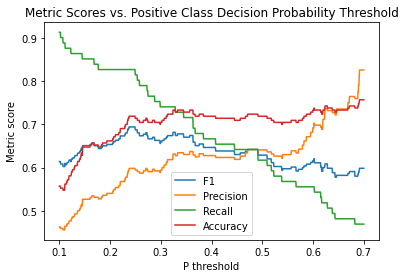

In [70]:
## Threshold adjustment

thresh_ps = np.linspace(.10,.70,1000)
model_val_probs = lm15.predict_proba(X_val_2)[:,1] # positive class probs

f1_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f1_scores.append(f1_score(y_test_val, model_val_labels))    
    prec_scores.append(precision_score(y_test_val, model_val_labels))
    rec_scores.append(recall_score(y_test_val, model_val_labels))
    acc_scores.append(accuracy_score(y_test_val, model_val_labels))
    
plt.plot(thresh_ps, f1_scores)
plt.plot(thresh_ps, prec_scores)
plt.plot(thresh_ps, rec_scores)
plt.plot(thresh_ps, acc_scores)

plt.title('Metric Scores vs. Positive Class Decision Probability Threshold')
plt.legend(['F1','Precision','Recall','Accuracy'])
plt.xlabel('P threshold')
plt.ylabel('Metric score')

best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('Best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

The new feature improved F1 slightly after using SMOTE and adding class weight.

## Extract titles in names
My intention was to find potential marital status information of passengers from their names, but it's impossible to get marital information from male passengers, so I'll just extract name title from each passenger and see how this feature would influence prediction.

In [71]:
df_3['title'] = ''
for index, row in df_3.iterrows():
    result = re.search('(Miss)|(Mrs)|(Mr)|(Mme)|(Mlle)|(Master)|(Col)|(Dr)|(Major)|(Rev)|(Ms)',row['name'])
    if(result):
        assign = result.group(0)
    else:
        assign = 'unknown'
    df_3.at[index,'title'] = assign

In [72]:
df_3.title.value_counts()

Mr         748
Miss       257
Mrs        196
Master      60
Col         14
Dr          14
Rev          8
unknown      5
Major        2
Ms           2
Mlle         2
Mme          1
Name: title, dtype: int64

In [73]:
df_3.loc[((df_3.title == 'unknown')&(df_3.sex == 'male')), 'title'] = 'Mr'
df_3.loc[((df_3.title == 'unknown')&(df_3.sex == 'female')), 'title'] = 'Miss'

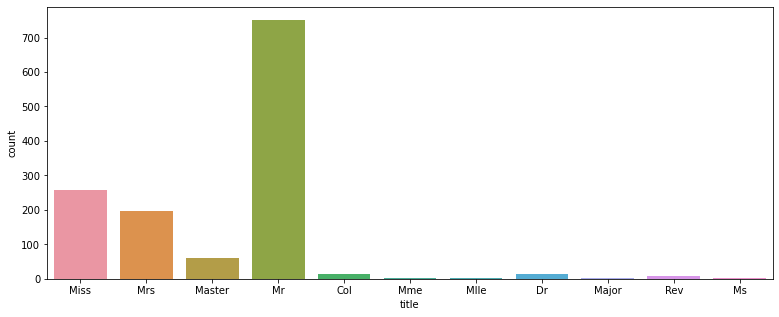

In [74]:
plt.figure(figsize=(13,5))
sns.countplot(x = 'title', data = df_3)

In [75]:
df_3.head(10)

,pclass,survived,name,sex,age,sibsp,parch,fare,embarked,group_size,individual_fare,fam_size,title
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,211.3375,S,4,52.834375,0,Miss
1,1,1,"Kreuchen, Miss. Emilie",female,39.0000,0,0,211.3375,S,4,52.834375,0,Miss
2,1,1,"Madill, Miss. Georgette Alexandra",female,15.0000,0,1,211.3375,S,4,52.834375,1,Miss
3,1,1,"Robert, Mrs. Edward Scott (Elisabeth Walton Mc...",female,43.0000,0,1,211.3375,S,4,52.834375,1,Mrs
4,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,151.5500,S,6,25.258333,3,Master
5,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,151.5500,S,6,25.258333,3,Miss
6,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,151.5500,S,6,25.258333,3,Mr
7,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,151.5500,S,6,25.258333,3,Mrs
8,1,1,"Cleaver, Miss. Alice",female,22.0000,0,0,151.5500,S,6,25.258333,0,Miss
9,1,1,"Daniels, Miss. Sarah",female,33.0000,0,0,151.5500,S,6,25.258333,0,Miss


In [76]:
df_4 = df_3.copy()
df_4.drop(columns=['name'], inplace = True)

In [77]:
df_4

,pclass,survived,sex,age,sibsp,parch,fare,embarked,group_size,individual_fare,fam_size,title
0,1,1,female,29.0000,0,0,211.3375,S,4,52.834375,0,Miss
1,1,1,female,39.0000,0,0,211.3375,S,4,52.834375,0,Miss
2,1,1,female,15.0000,0,1,211.3375,S,4,52.834375,1,Miss
3,1,1,female,43.0000,0,1,211.3375,S,4,52.834375,1,Mrs
4,1,1,male,0.9167,1,2,151.5500,S,6,25.258333,3,Master
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,0,female,14.5000,1,0,14.4542,C,2,7.227100,1,Miss
1305,3,0,female,28.0000,1,0,14.4542,C,2,7.227100,1,Miss
1306,3,0,male,26.5000,0,0,7.2250,C,1,7.225000,0,Mr
1307,3,0,male,27.0000,0,0,7.2250,C,1,7.225000,0,Mr


/Users/cynthiawang/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


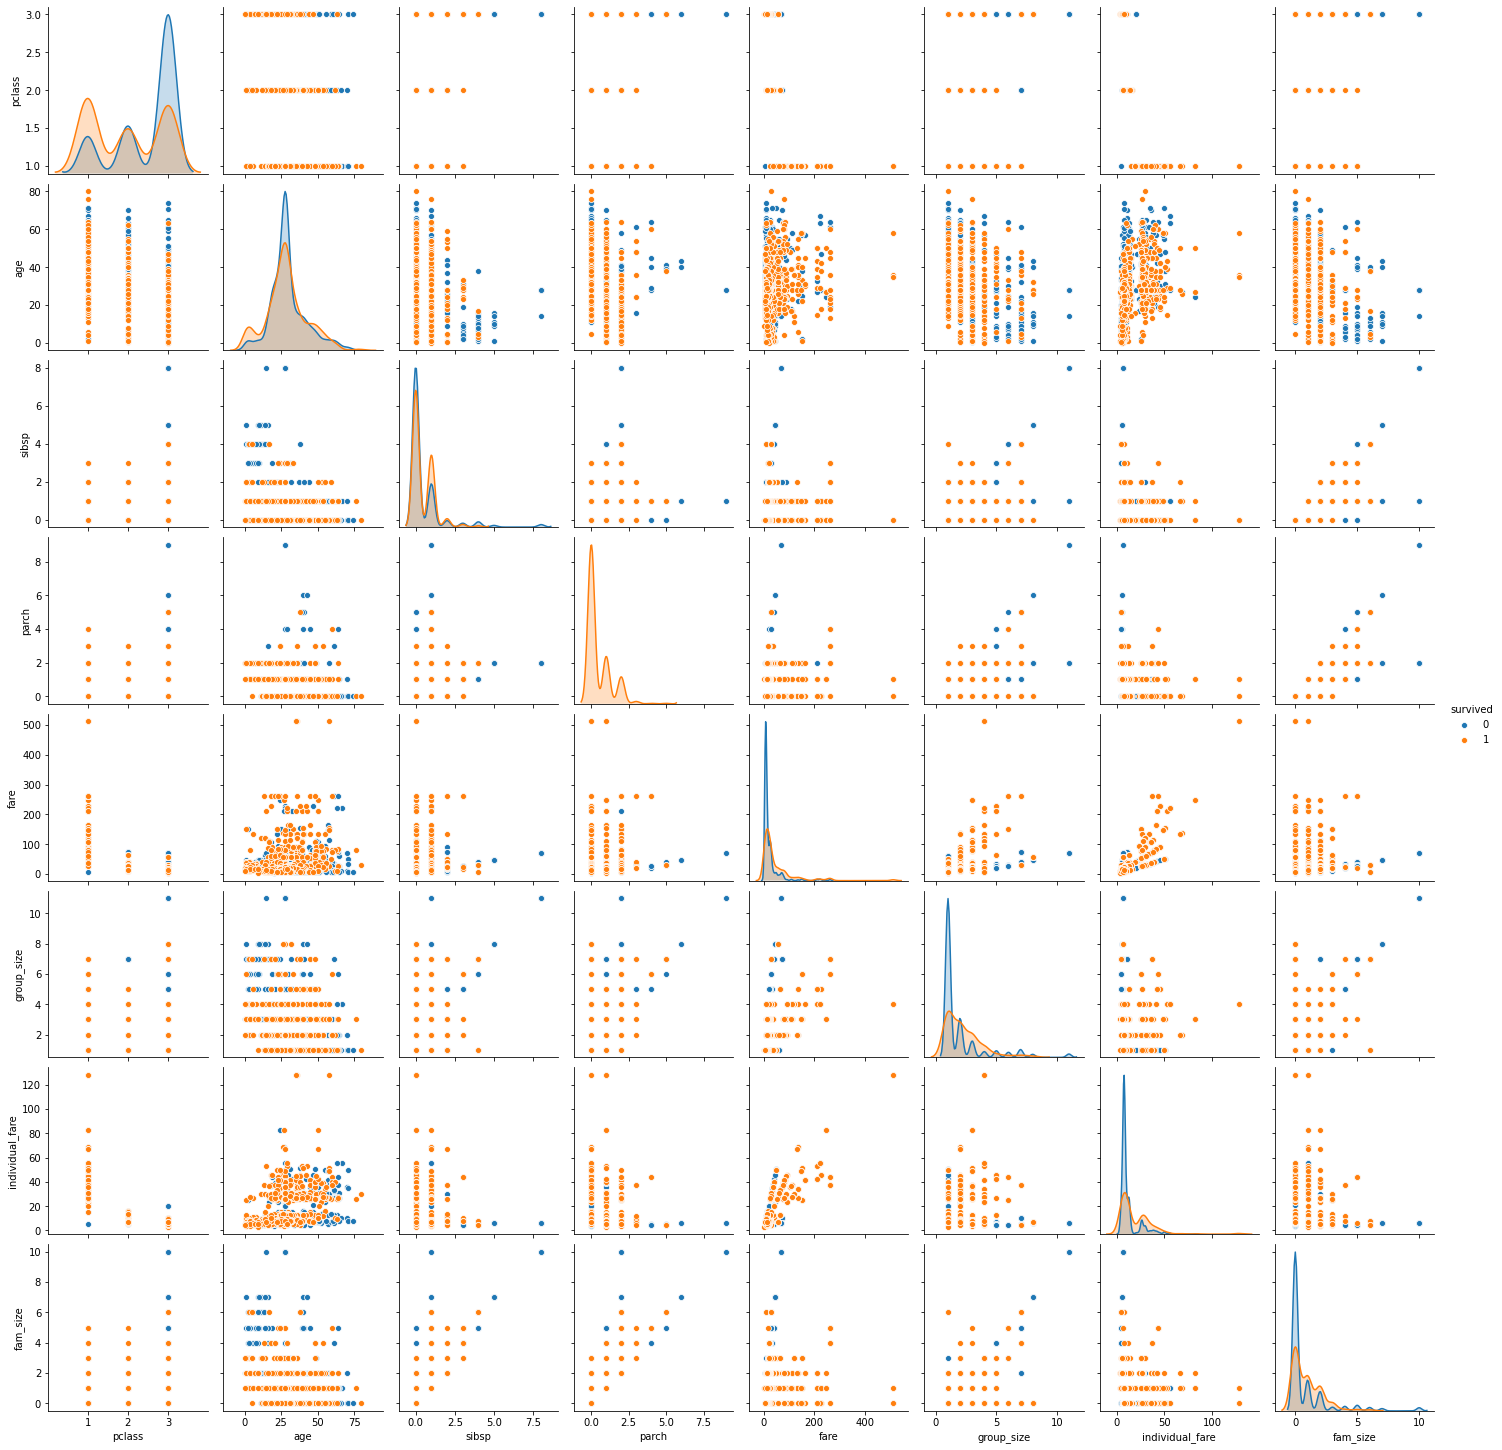

In [78]:
sns.pairplot(df_4,hue = 'survived')

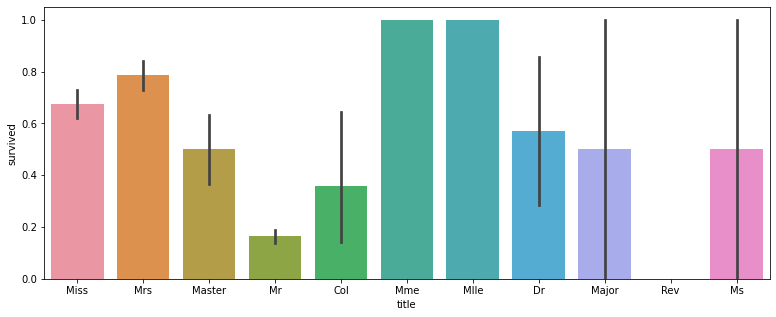

In [79]:
plt.figure(figsize=(13,5))
sns.barplot(x = 'title',y='survived',data=df_4)

In [80]:
X_train_new2, X_test_new2, y_train, y_test = train_test_split(df_4.drop(columns = ['survived']), df_4.survived, 
                                                    test_size = 0.2, random_state=42)

In [81]:
X_train_3 = X_train_new2.copy()
X_train_3 = pd.get_dummies(X_train_3,drop_first = True)
X_train_3

,pclass,age,sibsp,parch,fare,group_size,individual_fare,fam_size,sex_male,embarked_Q,embarked_S,title_Dr,title_Major,title_Master,title_Miss,title_Mlle,title_Mr,title_Mrs,title_Ms,title_Rev
772,3,30.0,0,0,9.5000,1,9.500000,0,1,0,1,0,0,0,0,0,1,0,0,0
543,2,30.0,0,0,12.7375,1,12.737500,0,1,0,0,0,0,0,0,0,1,0,0,0
289,1,56.0,0,0,26.5500,1,26.550000,0,1,0,1,0,0,0,0,0,1,0,0,0
10,1,48.0,0,0,26.5500,1,26.550000,0,1,0,1,0,0,0,0,0,1,0,0,0
147,1,39.0,1,1,110.8833,4,27.720825,2,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,3,32.0,0,0,7.7750,1,7.775000,0,1,0,1,0,0,0,0,0,1,0,0,0
1130,3,28.0,0,0,8.1375,1,8.137500,0,0,1,0,0,0,0,1,0,0,0,0,0
1294,3,28.0,0,0,7.5500,1,7.550000,0,1,0,1,0,0,0,0,0,1,0,0,0
860,3,20.0,0,0,9.5000,1,9.500000,0,1,0,1,0,0,0,0,0,1,0,0,0


In [82]:
X_train_3, X_val_3, y_train_val, y_test_val = train_test_split(X_train_3, y_train, test_size = 0.2
                                                                     , random_state=42)

In [83]:
## Logistic regression

lm18 = LogisticRegression(C=1, solver='liblinear')
lm18.fit(X_train_3, y_train_val)

y_predict_val = lm18.predict(X_val_3)

print('accuracy:', accuracy_score(y_test_val, y_predict_val))
print('precision:', precision_score(y_test_val, y_predict_val))
print('recall:', recall_score(y_test_val, y_predict_val))
print('F1:', f1_score(y_test_val,y_predict_val))
print('Coefficient:', lm18.coef_)

# F1 increased!

accuracy: 0.7428571428571429
precision: 0.6708860759493671
recall: 0.654320987654321
F1: 0.6625
Coefficient: [[-0.65990735 -0.02196809 -0.22622952  0.11283413  0.00352948 -0.17569709
   0.01886685 -0.11339539 -1.308471   -0.33790199 -0.24610864  0.29652561
   0.10498518  1.84735522  0.92512535  0.12162833 -0.64307806  1.26516757
  -0.31658939 -0.63412245]]


In [84]:
## Oversampling

X_train_3S, y_train_valS = smote.fit_sample(X_train_3, y_train_val)

lm19 = LogisticRegression(C=10, solver='liblinear')
lm19.fit(X_train_3S, y_train_valS)

y_predict_val = lm19.predict(X_val_3)

print('accuracy:', accuracy_score(y_test_val, y_predict_val))
print('precision:', precision_score(y_test_val, y_predict_val))
print('recall:', recall_score(y_test_val, y_predict_val))
print('F1:', f1_score(y_test_val,y_predict_val))

accuracy: 0.7380952380952381
precision: 0.6547619047619048
recall: 0.6790123456790124
F1: 0.6666666666666667


In [85]:
# Class weights

lm20 = LogisticRegression(class_weight='balanced', solver='liblinear',C=10)
lm20.fit(X_train_3, y_train_val)

y_predict_val = lm20.predict(X_val_3)

print('accuracy:', accuracy_score(y_test_val, y_predict_val))
print('precision:', precision_score(y_test_val, y_predict_val))
print('recall:', recall_score(y_test_val, y_predict_val))
print('F1:', f1_score(y_test_val,y_predict_val))

accuracy: 0.7333333333333333
precision: 0.6373626373626373
recall: 0.7160493827160493
F1: 0.6744186046511628


Best F1 score 0.705 at prob decision threshold >= 0.245


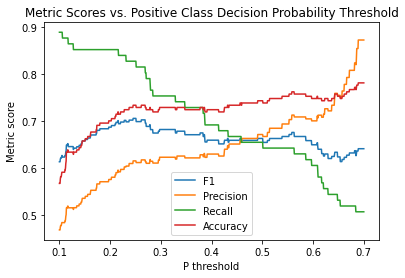

In [86]:
## Threshold adjustment

thresh_ps = np.linspace(.10,.70,1000)
model_val_probs = lm18.predict_proba(X_val_3)[:,1] # positive class probs

f1_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f1_scores.append(f1_score(y_test_val, model_val_labels))    
    prec_scores.append(precision_score(y_test_val, model_val_labels))
    rec_scores.append(recall_score(y_test_val, model_val_labels))
    acc_scores.append(accuracy_score(y_test_val, model_val_labels))
    
plt.plot(thresh_ps, f1_scores)
plt.plot(thresh_ps, prec_scores)
plt.plot(thresh_ps, rec_scores)
plt.plot(thresh_ps, acc_scores)

plt.title('Metric Scores vs. Positive Class Decision Probability Threshold')
plt.legend(['F1','Precision','Recall','Accuracy'])
plt.xlabel('P threshold')
plt.ylabel('Metric score')

best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('Best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

# Coming back from models

## Combine some titles

Judging by feature importance plots from logistic regression and random forest (in the models notebook), some titles with few observations are less important and they could be combined with other categories.

In [87]:
df_5 = df_4.copy()

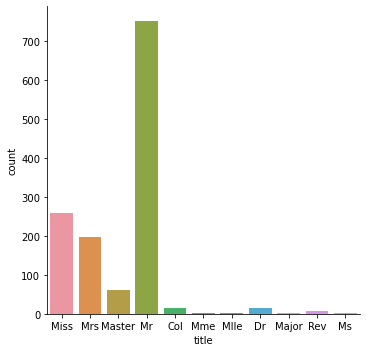

In [88]:
sns.catplot(x = 'title', kind = 'count', data = df_5);

In [89]:
# In France, one traditionally calls a young, unmarried woman Mademoiselle – Mlle for short – and
# an older, married woman Madame, whose abbreviation is Mme. 

df_5.loc[(df_5.title == 'Mme'), 'title'] = 'Mrs'
df_5.loc[(df_5.title == 'Mlle'), 'title'] = 'Miss'

In [90]:
# 'Ms' is omitted previously (should be 'Miss')

df_5.loc[(df_5.title == 'Ms'), 'title'] = 'Miss'

In [91]:
df_5.loc[(df_5.title == 'Col')]

,pclass,survived,sex,age,sibsp,parch,fare,embarked,group_size,individual_fare,fam_size,title
18,1,0,male,47.0,1,0,227.5250,C,5,45.5050,1,Col
110,1,0,male,47.0,0,0,25.5875,S,1,25.5875,0,Col
180,1,1,male,53.0,0,0,28.5000,C,1,28.5000,0,Col
287,1,1,male,56.0,0,0,35.5000,C,1,35.5000,0,Col
314,1,0,male,60.0,0,0,26.5500,S,1,26.5500,0,Col
378,2,0,male,29.0,0,0,10.5000,S,1,10.5000,0,Col
379,2,0,male,28.0,0,0,13.0000,S,1,13.0000,0,Col
380,2,1,male,24.0,0,0,10.5000,S,1,10.5000,0,Col
381,2,1,female,8.0,0,2,26.2500,S,3,8.7500,2,Col
382,2,0,male,31.0,1,1,26.2500,S,3,8.7500,2,Col


In [92]:
# 2 female 'Colonels' seem to be in the same family; wife and daughter

df_5.loc[((df_5.title == 'Col')&(df_5.sex == 'female')&(df_5.age == 8)), 'title'] = 'Miss'
df_5.loc[((df_5.title == 'Col')&(df_5.sex == 'female')&(df_5.age == 31)), 'title'] = 'Mrs'
df_5.loc[(df_5.title == 'Col'), 'title'] = 'Mr'

In [93]:
df_5.loc[(df_5.title == 'Major')]

,pclass,survived,sex,age,sibsp,parch,fare,embarked,group_size,individual_fare,fam_size,title
79,1,0,male,45.0,0,0,26.55,S,1,26.55,0,Major
268,1,1,male,52.0,0,0,30.50,S,1,30.50,0,Major


In [94]:
df_5.loc[(df_5.title == 'Major'), 'title'] = 'Mr'

In [95]:
df_5.loc[(df_5.title == 'Rev')]

,pclass,survived,sex,age,sibsp,parch,fare,embarked,group_size,individual_fare,fam_size,title
335,2,0,male,51.0,0,0,12.525,S,1,12.525,0,Rev
358,2,0,male,42.0,0,0,13.000,S,1,13.000,0,Rev
370,2,0,male,54.0,1,0,26.000,S,2,13.000,1,Rev
445,2,0,male,28.0,0,1,33.000,S,3,11.000,1,Rev
481,2,0,male,57.0,0,0,12.350,Q,1,12.350,0,Rev
485,2,0,male,30.0,1,1,26.000,S,2,13.000,2,Rev
515,2,0,male,27.0,0,0,13.000,S,1,13.000,0,Rev
539,2,0,male,41.0,0,0,13.000,S,1,13.000,0,Rev


In [96]:
df_5.loc[(df_5.title == 'Rev'), 'title'] = 'Mr'

In [97]:
df_5.loc[(df_5.title == 'Dr')]

,pclass,survived,sex,age,sibsp,parch,fare,embarked,group_size,individual_fare,fam_size,title
72,1,0,male,28.0,0,0,39.6000,C,1,39.600000,0,Dr
127,1,1,male,53.0,1,1,81.8583,S,3,27.286100,2,Dr
157,1,1,male,50.0,2,0,133.6500,S,2,66.825000,2,Dr
225,1,1,female,49.0,0,0,25.9292,S,1,25.929200,0,Dr
245,1,0,male,44.0,2,0,90.0000,Q,3,30.000000,2,Dr
296,1,1,male,32.0,0,0,30.5000,C,1,30.500000,0,Dr
411,2,1,male,8.0,0,2,32.5000,S,3,10.833333,2,Dr
412,2,0,male,42.0,1,1,32.5000,S,3,10.833333,2,Dr
413,2,1,female,34.0,1,1,32.5000,S,3,10.833333,2,Dr
516,2,0,male,54.0,0,0,14.0000,S,1,14.000000,0,Dr


In [98]:
df_5.loc[((df_5.title == 'Dr')&(df_5.sex == 'female')), 'title'] = 'Miss' # overall at young age
df_5.loc[((df_5.title == 'Dr')&(df_5.sex == 'male')), 'title'] = 'Mr'

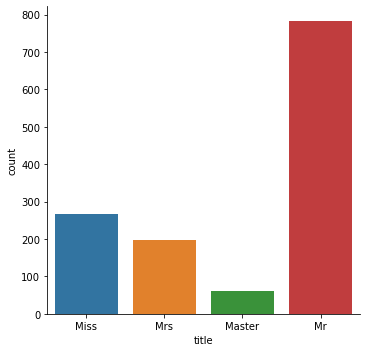

In [99]:
sns.catplot(x = 'title', kind = 'count', data = df_5);

# keep 'master' as a seperate title because it is relatively more important than other combined features 

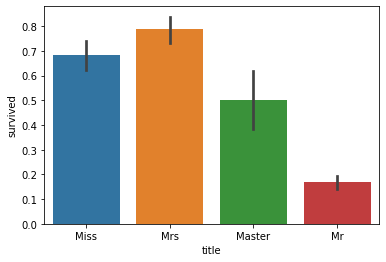

In [100]:
sns.barplot(x = 'title',y='survived',data=df_5);

This process improves F1 in logistic regression (checked model performance in the other notebook)

## Bin age

Age has low feature importance. Try binning ages into different age groups and see if this can improve F1 score.

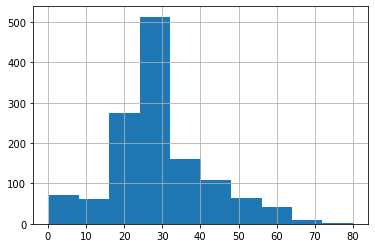

In [101]:
df_5.age.hist();

In [102]:
df_6 = df_5.copy()

In [103]:
df_6['age_group'] = pd.cut(x=df_6['age'], bins=[0, 12, 18, 25, 35, 45, 100],
                           labels=['less_than_12', '12-18', '18-25', '25-35', '35-45', 'more_than_45'])

In [104]:
df_6

,pclass,survived,sex,age,sibsp,parch,fare,embarked,group_size,individual_fare,fam_size,title,age_group
0,1,1,female,29.0000,0,0,211.3375,S,4,52.834375,0,Miss,25-35
1,1,1,female,39.0000,0,0,211.3375,S,4,52.834375,0,Miss,35-45
2,1,1,female,15.0000,0,1,211.3375,S,4,52.834375,1,Miss,12-18
3,1,1,female,43.0000,0,1,211.3375,S,4,52.834375,1,Mrs,35-45
4,1,1,male,0.9167,1,2,151.5500,S,6,25.258333,3,Master,less_than_12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,0,female,14.5000,1,0,14.4542,C,2,7.227100,1,Miss,12-18
1305,3,0,female,28.0000,1,0,14.4542,C,2,7.227100,1,Miss,25-35
1306,3,0,male,26.5000,0,0,7.2250,C,1,7.225000,0,Mr,25-35
1307,3,0,male,27.0000,0,0,7.2250,C,1,7.225000,0,Mr,25-35


In [106]:
import pickle
with open('titanic_for_model.pickle', 'wb') as to_write:
    pickle.dump(df_6, to_write)

While the effect of binning age on logistic regression is small, F1 is improved in random forest.

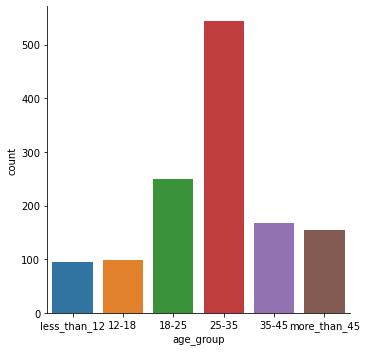

In [107]:
sns.catplot(x = 'age_group', kind = 'count', data = df_6);

# There are a lot more people in 25-35 because missing values are filled using median.

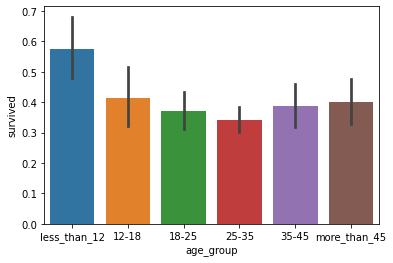

In [108]:
sns.barplot(x = 'age_group',y='survived',data=df_6);

Binning age slightly improved performance of RF model.

# Pure Visualizations

Generate all the visualizations using the same color palette.

## Categorical variables vs. Target

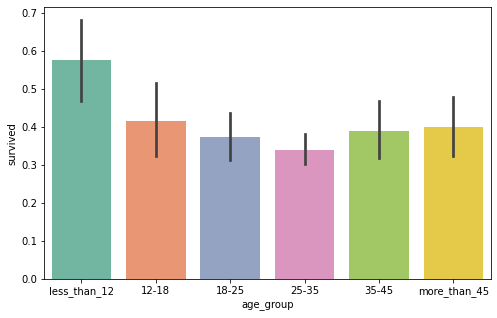

In [109]:
plt.figure(figsize=(8,5))
with sns.color_palette("Set2"):
    sns.barplot(x = 'age_group',y='survived',data=df_6)

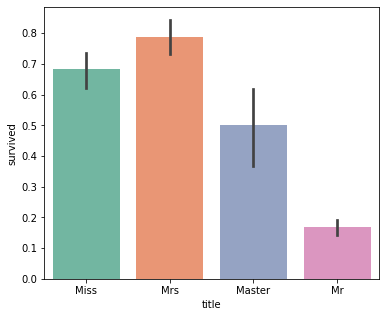

In [110]:
plt.figure(figsize=(6,5))
with sns.color_palette("Set2"):
    sns.barplot(x = 'title',y='survived',data=df_6)

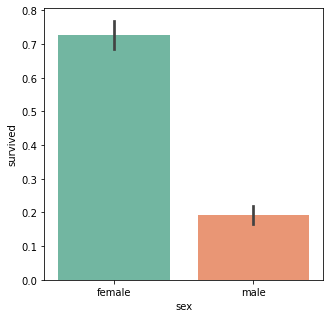

In [111]:
plt.figure(figsize=(5,5))
with sns.color_palette("Set2"):
    sns.barplot(x = 'sex',y='survived',data=df_6)

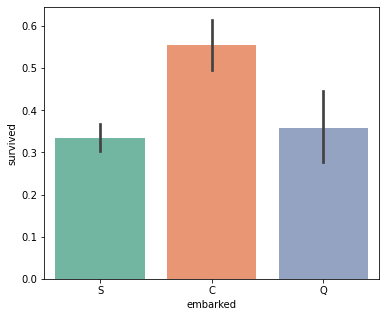

In [112]:
plt.figure(figsize=(6,5))
with sns.color_palette("Set2"):
    sns.barplot(x = 'embarked',y='survived',data=df_6)

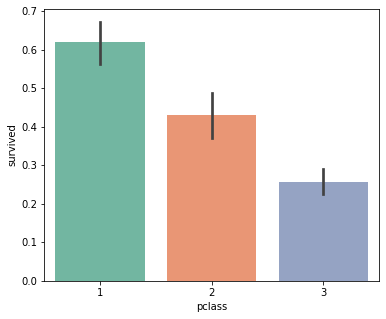

In [113]:
plt.figure(figsize=(6,5))
with sns.color_palette("Set2"):
    sns.barplot(x = 'pclass',y='survived',data=df_6)

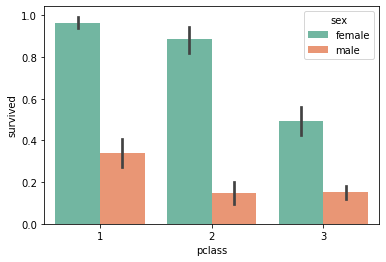

In [114]:
with sns.color_palette("Set2"):
    sns.barplot(x = 'pclass',y='survived',hue = 'sex',data=df_6)

## Continuous variables vs. Target

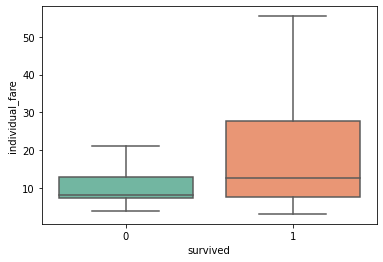

In [115]:
with sns.color_palette("Set2"):
    sns.boxplot(x = 'survived',y='individual_fare',data=df_6, showfliers = False)

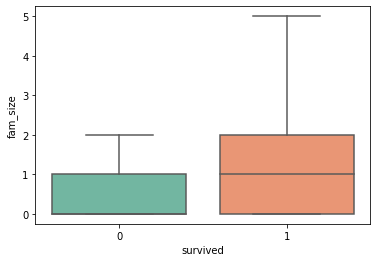

In [116]:
with sns.color_palette("Set2"):
    sns.boxplot(x = 'survived',y='fam_size',data=df_6, showfliers = False)

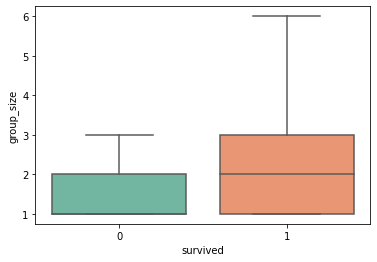

In [117]:
with sns.color_palette("Set2"):
    sns.boxplot(x = 'survived',y='group_size',data=df_6, showfliers = False)

/Users/cynthiawang/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


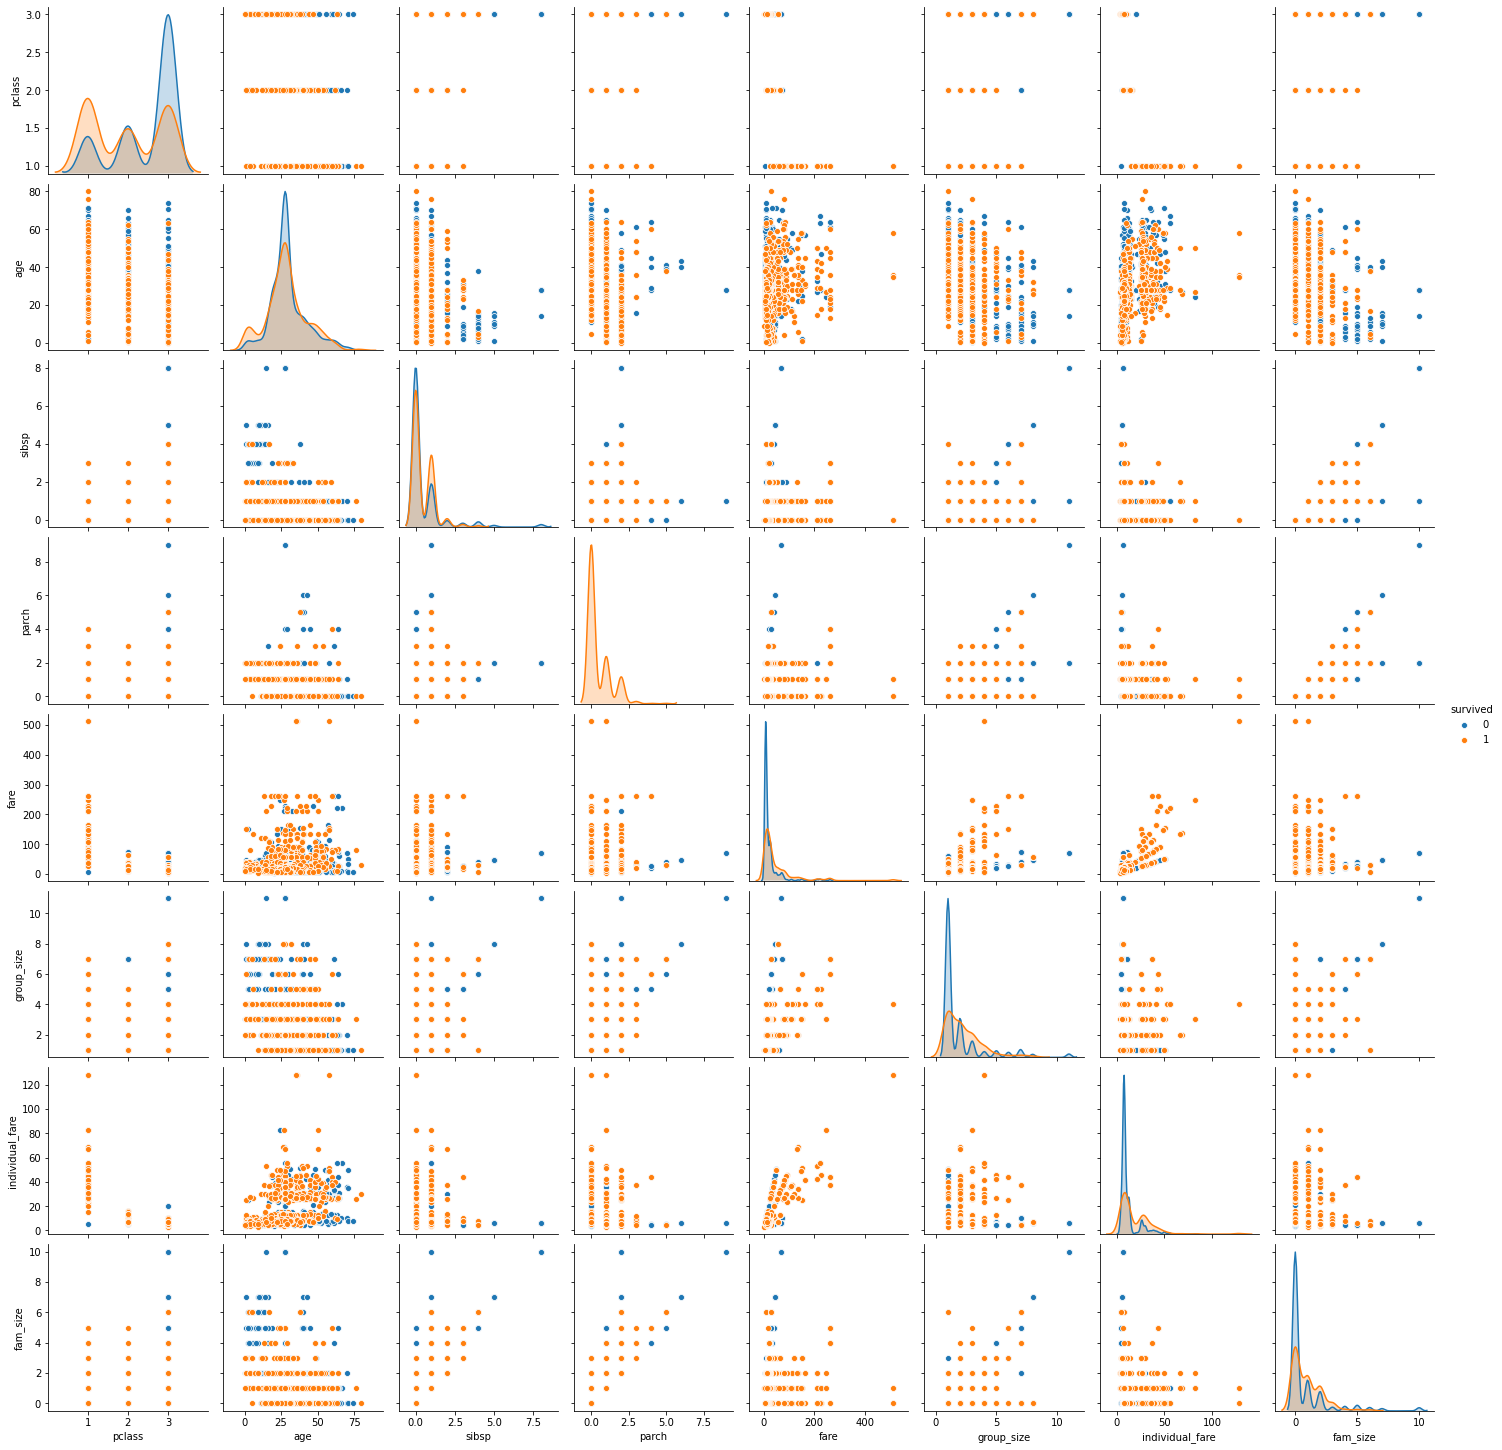

In [118]:
sns.pairplot(df_6,hue = 'survived')
plt.savefig('pairplot.png')